In [1]:
# import tensorflow.compat.v1 as tf
import tensorflow as tf
import numpy as np
import os
import PIL.Image
from matplotlib import pylab as P
import functools
import sys
sys.path.insert(0, './src/image_level/libml')
import utils

%matplotlib inline

In [2]:
tf.__version__

'1.15.0'

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [4]:
ViewLabel_to_Name_mapping = {0:'PLAX', 1:'PSAX', 2:'Other'}
DiagnosisLabel_to_Name_mapping = {0:'No AS', 1:'Mild/Moderate AS', 2:'Severe AS'}

## Utility methods

In [5]:
def normalize_to_be_the_same_value_seen_by_model(image):
    
    image = image[:,:,np.newaxis] * 2.0 /255 - 1.0
    
    return image

In [6]:
# Boilerplate methods

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    
    P.imshow(im , cmap=P.cm.gray, vmin=0, vmax=1) #im is of float, 0-1

    P.title(title)

    
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im
    

## Construct model

In [7]:
dataset_mean = 0
dataset_std = 1
nclass = 3

In [8]:
hwc = [64, 64, 1]
scales = 4
filters = 32
repeat = 4
training = False 

In [9]:
def classifier(x, scales, filters, repeat, training, getter=None, **kwargs):
    del kwargs
    leaky_relu = functools.partial(tf.nn.leaky_relu, alpha=0.1)
    bn_args = dict(training=training, momentum=0.999)

    def conv_args(k, f):
        return dict(padding='same',
                    kernel_initializer=tf.random_normal_initializer(stddev=tf.rsqrt(0.5 * k * k * f)))

    def residual(x0, filters, stride=1, activate_before_residual=False):
        x = leaky_relu(tf.layers.batch_normalization(x0, **bn_args))
        if activate_before_residual:
            x0 = x

        x = tf.layers.conv2d(x, filters, 3, strides=stride, **conv_args(3, filters))
        x = leaky_relu(tf.layers.batch_normalization(x, **bn_args))
        x = tf.layers.conv2d(x, filters, 3, **conv_args(3, filters))

        if x0.get_shape()[3] != filters:
            x0 = tf.layers.conv2d(x0, filters, 1, strides=stride, **conv_args(1, filters))

        return x0 + x

    with tf.variable_scope('classify', reuse=tf.AUTO_REUSE, custom_getter=getter):
        y = tf.layers.conv2d((x - dataset_mean) / dataset_std, 16, 3, **conv_args(3, 16))
        for scale in range(scales):
            y = residual(y, filters << scale, stride=2 if scale else 1, activate_before_residual=scale == 0)
            for i in range(repeat - 1):
                y = residual(y, filters << scale)

        y = leaky_relu(tf.layers.batch_normalization(y, **bn_args))
        y = tf.reduce_mean(y, [1, 2])
        logits = tf.layers.dense(y, nclass, kernel_initializer=tf.glorot_normal_initializer())
    return logits

### Create the graph and load Diagnosis pretrained weights

In [10]:
model_path = '/cluster/tufts/hugheslab/zhuang12/MLHCCode_Release/models/E4VD-156-52/fold0_diagnosis'

graph1 = tf.get_default_graph()
sess1 = tf.Session(graph=graph1)
with graph1.as_default():
    
    x_in_diagnosis = tf.placeholder(tf.float32, [None] + hwc, 'x') #labeled images, after augmentation operation in data_pair.py
    
    logits_diagnosis = classifier(x_in_diagnosis, scales, filters, repeat, training=True, getter = None)
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_op = ema.apply(utils.model_vars())
    ema_getter = functools.partial(utils.getter_ema, ema)

    classify_op_diagnosis = tf.nn.softmax(classifier(x_in_diagnosis, scales, filters, repeat, getter=ema_getter, training=False))
    
    saver = tf.train.Saver()
    saver.restore(sess1, os.path.join(model_path,'best_validation_balanced_accuracy.ckpt'))
    



INFO:tensorflow:Restoring parameters from /cluster/tufts/hugheslab/zhuang12/MLHCCode_Release/models/E4VD-156-52/fold0_diagnosis/best_validation_balanced_accuracy.ckpt


### Create the graph and load View pretrained weights

In [11]:
model_path = '/cluster/tufts/hugheslab/zhuang12/MLHCCode_Release/models/E4VD-156-52/fold0_view'

# tf.reset_default_graph()
graph2 = tf.Graph()
sess2 = tf.Session(graph=graph2)
with graph2.as_default():
    x_in_view = tf.placeholder(tf.float32, [None] + hwc, 'x') #labeled images, after augmentation operation in data_pair.py
    logits_view = classifier(x_in_view, scales, filters, repeat, training, getter=None)

    classify_op_view = tf.nn.softmax(classifier(x_in_view, scales, filters, repeat, getter=ema_getter, training=False))
    
    saver = tf.train.Saver()
    saver.restore(sess2, os.path.join(model_path,'best_validation_balanced_accuracy.ckpt'))


INFO:tensorflow:Restoring parameters from /cluster/tufts/hugheslab/zhuang12/MLHCCode_Release/models/E4VD-156-52/fold0_view/best_validation_balanced_accuracy.ckpt


### Load an image and infer

Predicted view label: PLAX
Predicted diagnosis label: Mild/Moderate AS


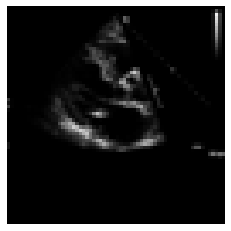

In [12]:
#load the image
target_image = LoadImage('./sample/sample.png') #We know the true label of this image is PLAX and Mild/Moderate AS (the third image in fold0 test set)
#show the image
ShowGrayscaleImage(target_image/255)

#Make predictions
this_image_input = normalize_to_be_the_same_value_seen_by_model(target_image)
diagnosis_predictions= sess1.run(classify_op_diagnosis, feed_dict={x_in_diagnosis:[this_image_input]})[0]
diagnosis_predicted_label = DiagnosisLabel_to_Name_mapping[np.argmax(diagnosis_predictions)]
view_predictions = sess2.run(classify_op_view, feed_dict={x_in_view:[this_image_input]})[0]
view_predicted_label = ViewLabel_to_Name_mapping[np.argmax(view_predictions)]

print('Predicted view label: {}'.format(view_predicted_label))
print('Predicted diagnosis label: {}'.format(diagnosis_predicted_label))